<a href="https://colab.research.google.com/github/bhavinithak/Kaggle_Paddy_Disease/blob/main/Paddy_Disease_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install timm
import timm

In [11]:
creds='{"username":"","key":""}'
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

path=Path('paddy-disease-classification')

if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

!ls {path}

sample_submission.csv  test_images  train.csv  train_images


In [12]:
from fastai.vision.all import *
set_seed(42)

#Data Prep

In [13]:
trn_path=path/'train_images'

files=get_image_files(trn_path)

(480, 640)


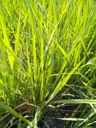

In [14]:
img=PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [15]:
from fastcore.parallel import *

In [16]:
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

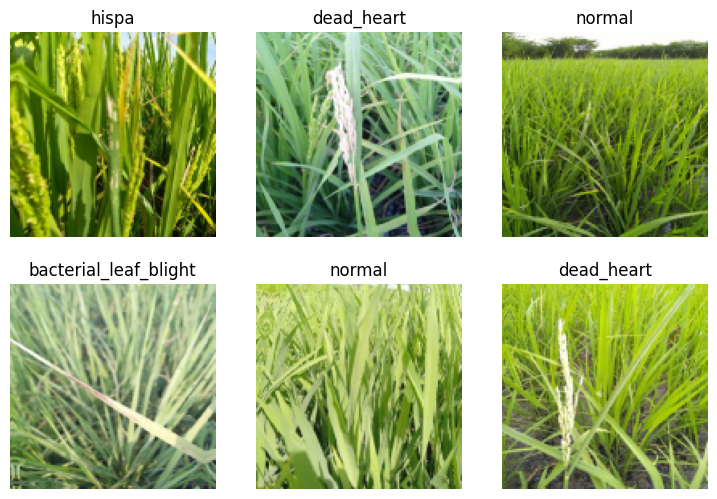

In [17]:
dls=ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,seed=42,
                                 item_tfms=Resize(480, method='squish'),
                                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

dls.show_batch(max_n= 6)

#Model RESNET

In [18]:
learn=vision_learner(dls,'resnet26d',metrics=error_rate,path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463, slide=0.004365158267319202)

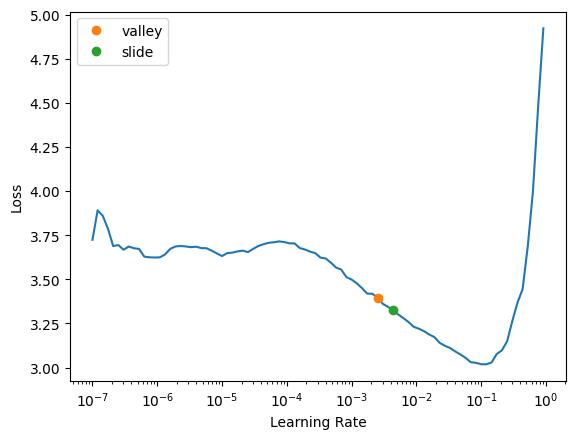

In [19]:
learn.lr_find(suggest_funcs=(valley, slide))

In [20]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.762535,1.235924,0.390197,01:23


epoch,train_loss,valid_loss,error_rate,time
0,1.162919,0.815291,0.277271,01:24
1,0.789095,0.485910,0.163383,01:24
2,0.553593,0.406724,0.128304,01:24


#Submitting to kaggle

In [21]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [22]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [23]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 4,  ..., 8, 1, 5])

In [24]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [25]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [26]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


#Model CONVNEXT

In [27]:
trn_path = Path('sml')

In [28]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True) #resize all images to run the models faster


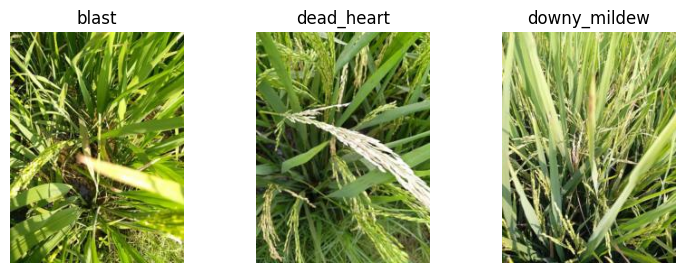

In [29]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In [30]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [31]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75)) #same error_rate but faster runtime for resnet

epoch,train_loss,valid_loss,error_rate,time
0,1.906185,1.652097,0.511773,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.279985,1.022028,0.338779,00:29
1,1.009654,0.714450,0.233542,00:30
2,0.697749,0.464544,0.155694,00:29
3,0.508761,0.382251,0.122057,00:29
4,0.437532,0.352824,0.115810,00:30


In [32]:
arch = 'convnext_small_in22k'

In [33]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75)) # better error_rate than resnet

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.307551,0.771851,0.242672,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.661719,0.405732,0.129745,00:43
1,0.502137,0.363103,0.110524,00:44
2,0.320466,0.224550,0.072561,00:43
3,0.186718,0.144117,0.039404,00:44
4,0.134072,0.128952,0.035560,00:49


#Preprocessing experiments

In [34]:
 ## remove squishing of images (default to crop images)
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.349894,0.737268,0.251802,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.695687,0.447335,0.140798,00:45
1,0.547737,0.367014,0.118693,00:52
2,0.367752,0.225510,0.068236,00:42
3,0.236726,0.164263,0.054781,00:45
4,0.169486,0.147046,0.044210,00:41


In [37]:
## Cropping has worse results than sqiush convnext

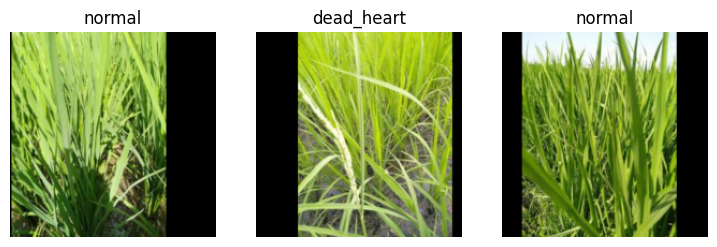

In [35]:
## Padding the images

dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [36]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.303952,0.740287,0.227775,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.680364,0.501038,0.156655,00:45
1,0.521042,0.344494,0.123979,01:00
2,0.369653,0.215389,0.068717,00:43
3,0.201559,0.135868,0.046612,00:43
4,0.132426,0.118440,0.038443,00:45


#Test time augmentation (TTA)

In [38]:
valid=learn.dls.valid
preds,targs=learn.get_preds(dl=valid)

In [39]:
error_rate(preds,targs)

TensorBase(0.0384)

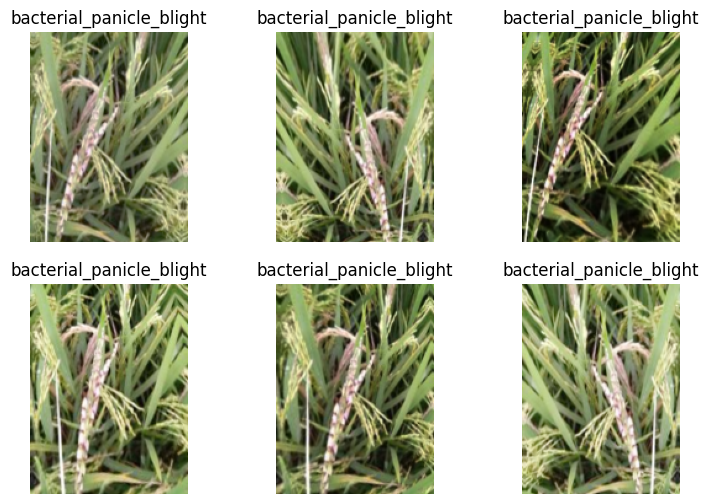

In [40]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [41]:
tta_preds,_ = learn.tta(dl=valid)

In [42]:
error_rate(tta_preds, targs)

TensorBase(0.0351)

#Scaling up

In [43]:
trn_path = path/'train_images'

In [44]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method='squish'),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.085676,0.613706,0.188852,01:45


epoch,train_loss,valid_loss,error_rate,time
0,0.506786,0.289203,0.093224,01:52
1,0.408643,0.283212,0.094185,01:52
2,0.357265,0.239757,0.079769,01:54
3,0.284032,0.228812,0.073042,01:54
4,0.241210,0.185023,0.051418,01:54
5,0.179525,0.161320,0.052379,01:54
6,0.133820,0.127457,0.037963,01:54
7,0.099595,0.108120,0.030754,01:57
8,0.078826,0.075425,0.024507,01:58
9,0.057597,0.065535,0.021144,01:57


In [45]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0197)

In [46]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [47]:
preds,_ = learn.tta(dl=tst_dl)

In [48]:
idxs = preds.argmax(dim=1)

In [49]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [50]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
